# ML model to recognize two-phase flows regimes

## Import modules

In [1]:
# Import modules
# ------------------------------------------------------------------------------ #
# Built-in modules
import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import glob
import random

# Third-party modules
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
# ------------------------------------------------------------------------------ #

## Image data generator

In [2]:
# Input data
# ------------------------------------------------------------------------------ #
n_img = 1000 # number of images to take from each run

# Labels
# 1 - Plug Flow; 2 - Transition Flow; 3 - Slug Flow

# Initialize lists
training_imgs = []
training_labels = []

# ------------------------------------------------------------------------------ #
# Data from Slug-Frequency campaign
# ------------------------------------------------------------------------------ #
IJMF_dir = '/media/psassi/URV/Paolo/URV/data/FastCam/3_Freq/Velocity/2P'
IJMF_regimes = [2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
#
dir_contents = os.listdir(IJMF_dir)
dir_contents.sort()
two_phase_runs = []
for run in dir_contents:
    if '2P' in run:
        two_phase_runs.append(os.path.join(IJMF_dir,run))
two_phase_runs.sort()
#
for i, run in enumerate(two_phase_runs):
    imgs_path = os.path.join(run, 'PPS_images', "*png")
    files = glob.glob(imgs_path)
    training_imgs.extend(random.sample(files,n_img))
    training_labels.extend([str(IJMF_regimes[i])]*n_img)
# ------------------------------------------------------------------------------ #

In [3]:
# ------------------------------------------------------------------------------ #
# Data from ECMF campaign
# ------------------------------------------------------------------------------ #
FTaC_dir = '/media/psassi/URV/Paolo/URV/data/FastCam/2_FTaC/Backlight/2P'
FTaC_regimes = [1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 3, 3, 2, 3, 3]
#
dir_contents = os.listdir(FTaC_dir)
dir_contents.sort()
FTaC_runs = []
for run in dir_contents:
    if '2P' in run:
        FTaC_runs.append(os.path.join(FTaC_dir,run))
FTaC_runs.sort()
#
for i, run in enumerate(FTaC_runs):
    imgs_path = os.path.join(run, 'PNG_images', "*png")
    files = glob.glob(imgs_path)
    training_imgs.extend(random.sample(files,n_img))
    training_labels.extend([str(FTaC_regimes[i])]*n_img)
# ------------------------------------------------------------------------------ #

In [4]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Make pandas Data Frame
two_phase_pd = pd.DataFrame(
    zip(training_imgs,training_labels), columns=['Files', 'Labels']
    )

# Divide training and testing data frames
train_df, test_df = train_test_split(two_phase_pd, test_size=0.2)

# Make train generator
train_generator = ImageDataGenerator().flow_from_dataframe(
    train_df,
    x_col='Files',
    y_col='Labels',
    target_size=(512, 256),
    color_mode='grayscale',
    class_mode='sparse',
    batch_size=64,
)

# Make test generator
test_generator = ImageDataGenerator().flow_from_dataframe(
    test_df,
    x_col='Files',
    y_col='Labels',
    target_size=(512, 256),
    color_mode='grayscale',
    class_mode='sparse',
    batch_size=64,
)

Found 31200 validated image filenames belonging to 3 classes.
Found 7800 validated image filenames belonging to 3 classes.


## Build the model

In [5]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 512x256 with 1 byte color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(512, 256, 1)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    tf.keras.layers.Dense(3, activation='softmax')  
])

model.summary()

2022-02-04 12:53:07.462104: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-04 12:53:07.470646: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-04 12:53:07.471314: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 510, 254, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 255, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 253, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 126, 62, 32)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 124, 60, 64)       18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 62, 30, 64)       0

2022-02-04 12:53:07.473005: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-04 12:53:07.473710: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-04 12:53:07.474000: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-04 12:53:07.474418: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [6]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [7]:
history = model.fit(
            train_generator,
            epochs=10,
            validation_data=test_generator,
            verbose=2
            )

Epoch 1/10


2022-02-04 12:53:30.182016: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8302
2022-02-04 12:53:30.365729: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


488/488 - 1876s - loss: 1.0584 - accuracy: 0.6837 - val_loss: 0.4702 - val_accuracy: 0.7950 - 1876s/epoch - 4s/step
Epoch 2/10
488/488 - 1354s - loss: 0.4150 - accuracy: 0.8195 - val_loss: 0.3477 - val_accuracy: 0.8540 - 1354s/epoch - 3s/step
Epoch 3/10
488/488 - 1315s - loss: 0.2948 - accuracy: 0.8724 - val_loss: 0.2965 - val_accuracy: 0.8744 - 1315s/epoch - 3s/step
Epoch 4/10
488/488 - 1290s - loss: 0.2336 - accuracy: 0.8982 - val_loss: 0.2209 - val_accuracy: 0.9033 - 1290s/epoch - 3s/step
Epoch 5/10
488/488 - 1129s - loss: 0.1729 - accuracy: 0.9262 - val_loss: 0.1633 - val_accuracy: 0.9303 - 1129s/epoch - 2s/step
Epoch 6/10
488/488 - 1310s - loss: 0.1361 - accuracy: 0.9418 - val_loss: 0.2086 - val_accuracy: 0.9191 - 1310s/epoch - 3s/step
Epoch 7/10
488/488 - 1211s - loss: 0.1091 - accuracy: 0.9549 - val_loss: 0.1491 - val_accuracy: 0.9350 - 1211s/epoch - 2s/step
Epoch 8/10
488/488 - 1552s - loss: 0.0965 - accuracy: 0.9604 - val_loss: 0.1280 - val_accuracy: 0.9464 - 1552s/epoch - 3s/

Text(0.5, 1.0, 'Training and validation loss')

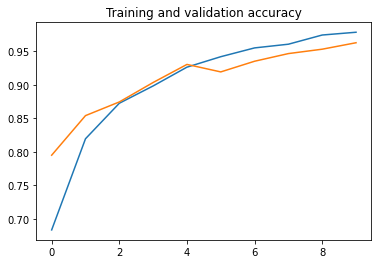

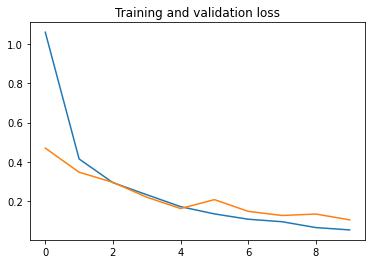

In [9]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )

In [8]:
model.save('./src/models/regime_identifier.h5')